# Three dims models reconstruction

This notebook demonstrates the process of 3D models reconstruction based on 3D spatial transcriptome data. This is done in the following five steps:

1. Construct the original 3D point cloud model (Embryo);
2. Construct the mesh model based on the 3D point cloud model (Embryo);
3. Construct the cell model based on the 3D point cloud model (Embryo);
4. Construct the voxel model based on the mesh model (Embryo);
5. Construct the subtype models based on the embryo model (CNS);

This example reconstructs 3D Drosophila Embryo/CNS models based on 3D spatial transcriptomics data of Drosophila Embryo.

## Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import spateo as st

2023-07-24 17:51:29.310557: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 17:51:29.332206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 17:51:29.677685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data source

In [6]:
# adata = st.sample_data.drosophila(filename="E7-9h_cellbin_tdr_v2.h5ad")
adata = st.read_h5ad("E7-9h_cellbin.h5ad")

spatial = adata.obsm["3d_align_spatial"]
del adata.obsm, adata.layers["log1p_X"], adata.layers["pearson_X"], adata.uns

adata.obs = adata.obs[["area", "slices", "anno_cell_type", "anno_tissue", "anno_germ_layer", "actual_stage"]]
adata.obsm["3d_align_spatial"] = spatial
adata

AnnData object with n_obs × n_vars = 25921 × 8136
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
    obsm: '3d_align_spatial'
    layers: 'counts_X', 'spliced', 'unspliced'

## 3D reconstruction of original point cloud model

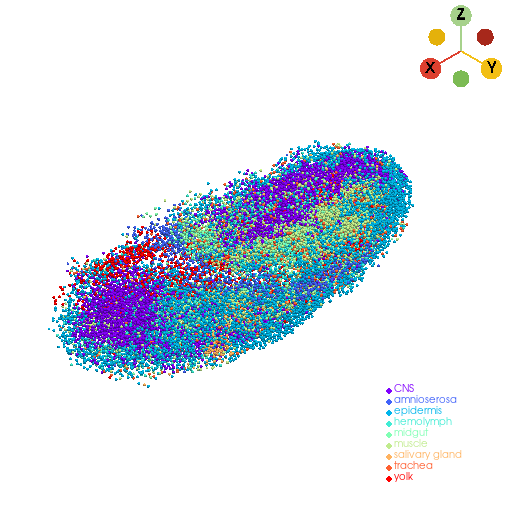

In [5]:
embryo_pc, plot_cmap = st.tdr.construct_pc(adata=adata.copy(), spatial_key="3d_align_spatial", groupby="anno_tissue", key_added="tissue", colormap="rainbow")
st.pl.three_d_plot(model=embryo_pc, key="tissue", model_style="points", colormap=plot_cmap, jupyter="static")
st.tdr.save_model(model=embryo_pc, filename="embryo_pc_model.vtk")

## 3D reconstruction of mesh model

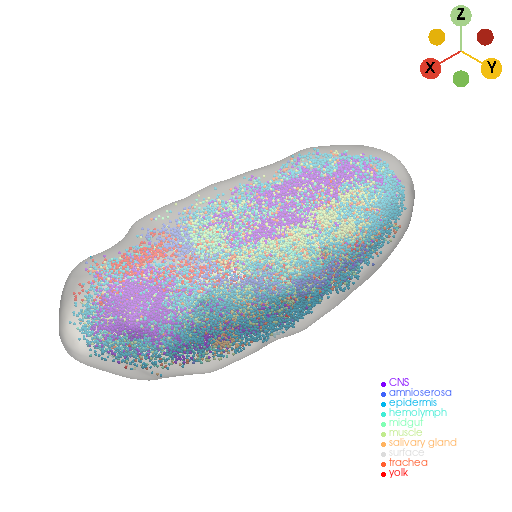

In [11]:
embryo_mesh, _, _ = st.tdr.construct_surface(pc=embryo_pc, key_added="tissue", alpha=0.6, cs_method="marching_cube", cs_args={"mc_scale_factor": 1.}, smooth=5000, scale_factor=1.05)
st.pl.three_d_plot(model=st.tdr.collect_models([embryo_mesh, embryo_pc]), key="tissue", model_style=["surface", "points"], jupyter="static")
st.tdr.save_model(model=embryo_mesh, filename="embryo_mesh_model.vtk")

## 3D reconstruction of cell mesh model

/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2135: UserWarning:

No vector-like data to use for orient. orient will be set to False.



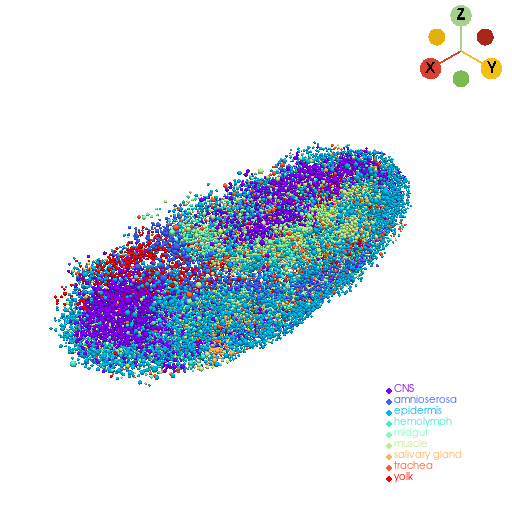

In [12]:
# Add cell radius info
obs_index = embryo_pc.point_data["obs_index"].tolist()
area = adata[obs_index, :].obs["area"].values
cell_radius = pow(np.asarray(area), 1 / 2)
st.tdr.add_model_labels(model=embryo_pc, labels=cell_radius, key_added="cell_radius", where="point_data", colormap="hot_r", inplace=True)
embryo_cells = st.tdr.construct_cells(pc=embryo_pc, cell_size=embryo_pc.point_data["cell_radius"], geometry="sphere", factor=0.2)
st.pl.three_d_plot(model=embryo_cells, key="tissue", jupyter="static")
st.tdr.save_model(model=embryo_cells, filename="embryo_cells_mesh_model.vtk")

## 3D reconstruction of voxel model

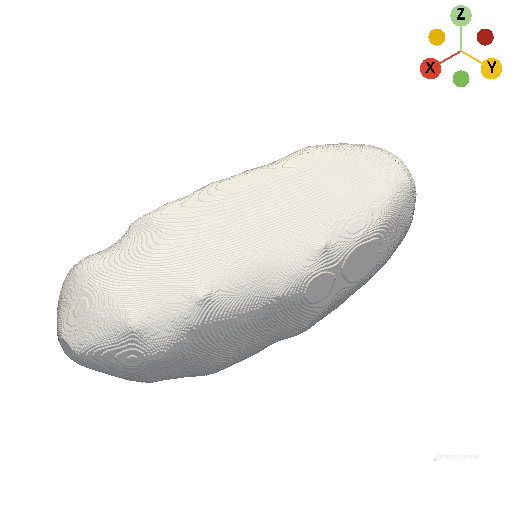

In [14]:
embryo_voxel, _ = st.tdr.voxelize_mesh(mesh=embryo_mesh, voxel_pc=None, key_added="tissue", label="embryo_voxel", color="gainsboro", smooth=500)
st.pl.three_d_plot(model=embryo_voxel, key="tissue", jupyter="static")
st.tdr.save_model(model=embryo_voxel, filename="embryo_voxel_model.vtk")

## 3D reconstruction of subtype models

In [18]:
subtype = "CNS"
subtype_rpc = st.tdr.three_d_pick(model=embryo_pc, key="tissue", picked_groups=subtype)[0]
subtype_tpc = st.tdr.interactive_rectangle_clip(model=subtype_rpc, key="tissue", invert=True)[0]

In [23]:
subtype_mesh, subtype_pc, _ = st.tdr.construct_surface(
    pc=subtype_tpc, key_added="tissue", label=subtype, color="purple", alpha=0.6, cs_method="marching_cube", cs_args={"mc_scale_factor": 0.8}, smooth=5000, scale_factor=1
)

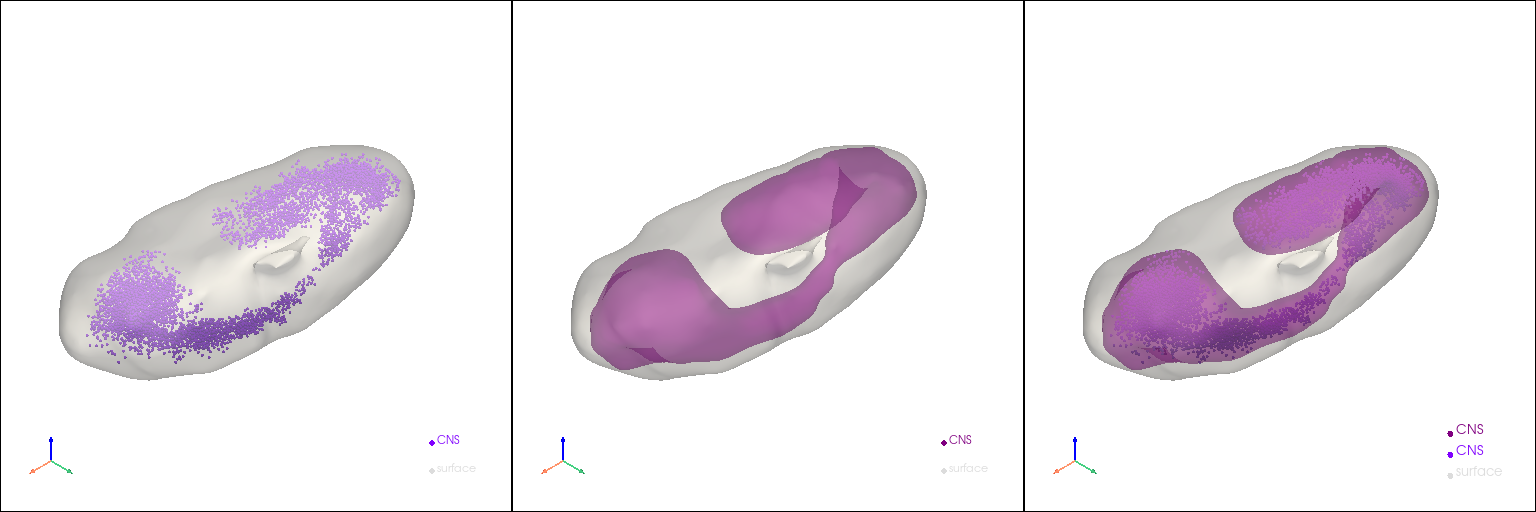

In [24]:
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models(
        [
            st.tdr.collect_models([embryo_mesh, subtype_pc]),
            st.tdr.collect_models([embryo_mesh, subtype_mesh]),
            st.tdr.collect_models([embryo_mesh, subtype_mesh, subtype_pc])
        ]
    ),
    key="tissue",
    model_style=[["surface", "points"], "surface", ["surface", "surface", "points"]],
    model_size=3,
    opacity=[1, 1, 1],
    shape=(1, 3),
    jupyter="static",
)